# Datasets creation

In [1]:
import os
from itertools import product

import numpy as np
import pandas as pd
from datasets import load_dataset
from functional import seq
from config import TAGS
from tqdm import tqdm

from map_generation.osm_dataset import TextToImageDataset
from srai.utils.geocode import geocode_to_region_gdf
from srai.loaders.osm_loaders.filters import GEOFABRIK_LAYERS, HEX2VEC_FILTER
from srai.regionizers import (
    SlippyMapRegionizer,
    H3Regionizer,
    AdministrativeBoundaryRegionizer,
)
from srai.loaders import OSMOnlineLoader
from srai.plotting.folium_wrapper import plot_regions
import geopandas as gpd
import pandas as pd
import shapely
import osmnx


tqdm.pandas()

In [2]:


class AdminLevels:
    def __init__(self, gdf: gpd.GeoDataFrame) -> None:
        self.admins: dict[int, gpd.GeoDataFrame] = {}
        self.region_gdf = gdf
        self.names: dict[str, str] = {}


def get_admin_level(poligon: shapely.Polygon, regions: AdminLevels):
    for i in range(11, 7, -1):
        if not i in regions.admins:
            try:
                print(f"Getting admin level {i}")
                region_admins_i = get_regionazer(i, regions)
                region_admins_i["name"] = region_admins_i.apply(
                    lambda x: get_place_name(x),
                    axis=1,
                )
                regions.admins[i] = region_admins_i
            except ValueError as e:
                regions.admins[i] = gpd.GeoDataFrame().set_geometry(pd.Series())
        intersections = regions.admins[i].geometry.intersects(poligon)
        if intersections.any():
            district = intersections[intersections].sample()
            row = regions.admins[i].loc[district.index].sample()
            return row.reset_index().iloc[0]
    return pd.Series(
        ["unknown", None, "unknown"], index=["region_id", "geometry", "name"]
    )


def get_regionazer(i, regions):
    try:
        regionazer = AdministrativeBoundaryRegionizer(i, toposimplify=1e-2)
        return regionazer.transform(regions.region_gdf)

    except RuntimeError:  # lower toposimplify
        regionazer = AdministrativeBoundaryRegionizer(i)
        return regionazer.transform(regions.region_gdf)


def get_place_name(x):
    try:
        places = osmnx.geometries_from_polygon(
            geocode_to_region_gdf(x.name).geometry.tolist()[0],
            {"place": True},
        ).reset_index()
        return "unknown" if places.shape[0] == 0 else places.iloc[0]["place"]
    except Exception as e:
        print(x.name)
        raise e


def process(geocode: str):
    city = geocode_to_region_gdf(geocode)
    r = SlippyMapRegionizer(zoom=16)
    tiles = r.transform(gdf=city)
    regions = AdminLevels(city)
    regions.admins[8] = AdministrativeBoundaryRegionizer(8).transform(city)
    tiles = tiles.progress_apply(
        lambda row: get_admin_level(r._polygon_from_x_y(row["x"], row["y"]), regions),
        axis=1,
    )
    try:
        return tiles.rename(columns={"region_id": "admin_region"})
    except TypeError:
        print("eee")

In [13]:

exists = seq(os.listdir("../data/admins")).map(lambda x: x.replace(".pkl", "")).to_set()
# exists.add("Helsinki, Finland")
# exists.add("Warszawa, PL")
# exists.add("Belgrade, Serbia")
# exists.add("Chicago, USA")
for city in tqdm(os.listdir("../data/tiles")):
    if city not in exists:
        print(city)
        data = process(city)
        data.to_pickle(f"../data/admins/{city}.pkl")
    else:
        print(city, "skipped")

data

  0%|          | 0/46 [00:00<?, ?it/s]

Berlin, Germany skipped
Chișinău, Moldova skipped
Sarajevo, Bosnia and Herzegovina skipped
Stockholm, Sweden skipped
Skopje, North Macedonia skipped
Bern, Switzerland skipped
Bucharest, Romania skipped
Prague, Czech Republic skipped
Baku, Azerbaijan skipped
Tbilisi, Georgia skipped
Latvia, Riga skipped
Helsinki, Finland


Loading boundaries: 5it [00:00, 106.42it/s]
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/topojson/core/dedup.py:107: RuntimeWarning: invalid value encountered in cast
  data["bookkeeping_shared_arcs"] = array_bk_sarcs.astype(np.int64).tolist()
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/srai/regionizers/administrative_boundary_regionizer.py:166: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  ].geometry.unary_union


Getting admin level 11
















Loading boundaries: 143it [00:01, 104.71it/s]
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/topojson/core/dedup.py:107: RuntimeWarning: invalid value encountered in cast
  data["bookkeeping_shared_arcs"] = array_bk_sarcs.astype(np.int64).tolist()













Loading boundaries: 143it [00:01, 105.71it/s]
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/topojson/core/dedup.py:107: RuntimeWarning: invalid value encountered in cast
  data["bookkeeping_shared_arcs"] = array_bk_sarcs.astype(np.int64).tolist()
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/srai/regionizers/administrative_boundary_regionizer.py:166: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  ].geometry.unary_union


Aurinkolahti
Getting admin level 10












Loading boundaries: 109it [00:01, 108.88it/s]
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/topojson/core/dedup.py:107: RuntimeWarning: invalid value encountered in cast
  data["bookkeeping_shared_arcs"] = array_bk_sarcs.astype(np.int64).tolist()
/home/marcin/Documents/mgr/projekt_n_w/own/.venv/lib/python3.11/site-packages/srai/regionizers/administrative_boundary_regionizer.py:166: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  ].geometry.unary_union


In [11]:
pds = []
for file in os.listdir("../data/admins"):
    pds.append(pd.read_pickle(f"../data/admins/{file}"))
df = pd.concat(pds)
df

,geometry,name,admin_region
region_id,,,
19063_24816_16,"POLYGON ((-75.27648 39.97698, -75.27123 39.979...",NaN,Philadelphia
19063_24817_16,"POLYGON ((-75.27648 39.97698, -75.27123 39.979...",NaN,Philadelphia
19064_24815_16,"POLYGON ((-75.27648 39.97698, -75.27123 39.979...",NaN,Philadelphia
19064_24816_16,"POLYGON ((-75.27648 39.97698, -75.27123 39.979...",NaN,Philadelphia
19064_24817_16,"POLYGON ((-75.27648 39.97698, -75.27123 39.979...",NaN,Philadelphia
...,...,...,...
36080_19305_16,"POLYGON ((18.11171 59.30182, 18.11227 59.30176...",suburb,Skarpnäcks stadsdelsområde
36080_19306_16,"POLYGON ((18.11171 59.30182, 18.11227 59.30176...",suburb,Skarpnäcks stadsdelsområde
36080_19307_16,"POLYGON ((18.11171 59.30182, 18.11227 59.30176...",suburb,Skarpnäcks stadsdelsområde


In [12]:
df["name"].value_counts()

name
suburb               27347
unknown              10348
neighbourhood         7202
quarter               5158
locality              4680
hamlet                4246
village               3150
city                  2764
town                  2695
square                 618
farm                   338
district               217
county                 194
island                 193
isolated_dwelling      107
city_block              38
Name: count, dtype: int64

In [7]:
exists

['Berlin, Germany',
 'Chișinău, Moldova',
 'Sarajevo, Bosnia and Herzegovina',
 'Stockholm, Sweden',
 'Skopje, North Macedonia',
 'Bern, Switzerland',
 'Bucharest, Romania',
 'Prague, Czech Republic',
 'Baku, Azerbaijan',
 'Tbilisi, Georgia',
 'Latvia, Riga',
 'Helsinki, Finland',
 'Zagreb, Croatia',
 'Paris, France',
 'Lisbon, Portugal',
 'San Francisco, USA',
 'Kraków, PL',
 'Yerevan, Armenia',
 'Vilnius, Lithuania',
 'Valletta, Malta',
 'Vienna, Austria',
 'Poznań, PL',
 'Łódź, PL',
 'Moscow, Russia',
 'Ljubljana, Slovenia',
 'Podgorica, Montenegro',
 'Tallinn, Estonia',
 'Madrid, Spain',
 'Szczecin, PL',
 'Warszawa, PL',
 'Wrocław, PL',
 'Brussels, Belgium',
 'Reykjavík, Iceland',
 'Belgrade, Serbia',
 'Gdańsk, PL',
 'Amsterdam, Netherlands',
 'Philadelphia, USA',
 'Luxembourg City, Luxembourg',
 'Sofia, Bulgaria',
 'Chicago, USA',
 'Bratislava, Slovakia',
 'Oslo, Norway',
 'Minsk, Belarus',
 'Dublin, Ireland',
 'Budapest, Hungary',
 'Los Angeles, USA']

In [22]:
data["name"].value_counts()

name
suburb           1501
village           238
neighbourhood     210
hamlet             75
town               72
quarter            37
city               10
8                   1
Name: count, dtype: int64

In [26]:
data

,admin_region,geometry,name
region_id,,,
35150_21522_16,Steglitz-Zehlendorf,"POLYGON ((13.12412 52.44067, 13.12688 52.44114...",suburb
35150_21523_16,Steglitz-Zehlendorf,"POLYGON ((13.12412 52.44067, 13.12688 52.44114...",suburb
35150_21524_16,Steglitz-Zehlendorf,"POLYGON ((13.12412 52.44067, 13.12688 52.44114...",suburb
35151_21522_16,Steglitz-Zehlendorf,"POLYGON ((13.12412 52.44067, 13.12688 52.44114...",suburb
35151_21523_16,Steglitz-Zehlendorf,"POLYGON ((13.12412 52.44067, 13.12688 52.44114...",suburb
...,...,...,...
35272_21514_16,Treptow-Köpenick,"POLYGON ((13.43988 52.49060, 13.44555 52.49486...",suburb
35272_21515_16,Treptow-Köpenick,"POLYGON ((13.43988 52.49060, 13.44555 52.49486...",suburb
35272_21516_16,Treptow-Köpenick,"POLYGON ((13.43988 52.49060, 13.44555 52.49486...",suburb


In [ ]:
for city in sorted(os.listdir("../data/admins/")):
    print(city)
    df = pd.read_pickle(f"../data/admins/{city}")
    display(pd.DataFrame(df).value_counts())

In [3]:
from srai.loaders import OSMOnlineLoader

loader = OSMOnlineLoader()
parks_filter = {"leisure": "park"}
gdf = r.transform(geocode_to_region_gdf("Wrocław, PL"))
loader.load(
    gdf,
    parks_filter
    # {
    #     # "administrative_level": seq(list(range(11))).map(lambda x: str(x)).to_list(),
    #     "building": "yes",
    # },
)

EmptyOverpassResponse: There are no data elements in the server response. Check log and query location/tags.

In [15]:
TAGS["aeroway"], {"admin_level": list(range(12))}["admin_level"]

(['aerodrome',
  'apron',
  'gate',
  'hangar',
  'helipad',
  'heliport',
  'navigationaid',
  'runway',
  'taxiway',
  'terminal',
  'windsock'],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

# Prepare data

In [2]:
def _flatten_tags(tags):
    tags_flat = (
        seq(tags.items())
        .starmap(lambda k, v: product([k], v if isinstance(v, list) else [v]))
        .flatten()
        .map(lambda x: "_".join(x))
        .list()
    )
    return tags_flat
columns = _flatten_tags(TAGS)
columns[:5]

['aeroway_aerodrome',
 'aeroway_apron',
 'aeroway_gate',
 'aeroway_hangar',
 'aeroway_helipad']

# Saving metadata to image folders
Code creates csv with tags in each city's tiles folder. Metadata.csv is used to generate captions.

Due to changes in srai.SippyMapRegionizer this code does not run with embeddings present in drive. You can skip this step - on drive are folders with created metadata.csv or use freshly created embeddings with previous notebook.

In [63]:
for city in tqdm(os.listdir("../data/tiles")):
    path_to_embedding = f"../data/embeddings_roads/{city}.pkl"
    if os.path.exists(path_to_embedding):
        df = pd.read_pickle(path_to_embedding)
        df = df.reindex(columns=columns, fill_value=0)
        df.index = df.index.str[:-3] + ".png"
        df.index = df.index.rename("file_name")
        df = df.reset_index()
        geocode = geocode_to_region_gdf(city).index[0]
        df.insert(0, "geocode", geocode)
        path = f"../data/tiles/{city}/metadata.jsonl"
        df.to_json(path, lines=True, orient="records")
    else :
        print(city, "not found")

100%|██████████| 46/46 [00:36<00:00,  1.25it/s]


In [10]:
df = pd.read_pickle(f"../data/embeddings_roads/{city}.pkl")
df = df.reindex(columns=columns, fill_value=0)
df.index = df.index + ".png"
df

,aeroway_aerodrome,aeroway_apron,aeroway_gate,aeroway_hangar,aeroway_helipad,aeroway_holding_position,aeroway_navigationaid,aeroway_parking_position,aeroway_runway,aeroway_taxiway,...,wheelchair_yes,wires_double,wires_single,wood_deciduous,wood_mixed,zone:traffic_BE-VLG:urban,zone:traffic_DE:rural,zone:traffic_DE:urban,zone:traffic_NL:rural,zone:traffic_NL:urban
region_id,,,,,,,,,,,,,,,,,,,,,
11165_26133_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26134_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26135_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26136_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11165_26137_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11257_26162_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11257_26163_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11257_26164_16.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Get prepared data and push to huggingface hub

In [4]:
# ds = TextToImageDataset("../data/tiles/Wrocław, PL")
ds = load_dataset("../data/tiles/Wrocław, PL")

Resolving data files:   0%|          | 0/2145 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/marcin/.cache/huggingface/datasets/imagefolder/Wrocław, PL-0f2dfdb028398a8b/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
ds["train"].features

{'image': Image(decode=True, id=None),
 'geocode': Value(dtype='string', id=None),
 'aeroway_aerodrome': Value(dtype='int64', id=None),
 'aeroway_apron': Value(dtype='int64', id=None),
 'aeroway_gate': Value(dtype='int64', id=None),
 'aeroway_hangar': Value(dtype='int64', id=None),
 'aeroway_helipad': Value(dtype='int64', id=None),
 'aeroway_holding_position': Value(dtype='int64', id=None),
 'aeroway_navigationaid': Value(dtype='int64', id=None),
 'aeroway_parking_position': Value(dtype='int64', id=None),
 'aeroway_runway': Value(dtype='int64', id=None),
 'aeroway_taxiway': Value(dtype='int64', id=None),
 'amenity_arts_centre': Value(dtype='int64', id=None),
 'amenity_atm': Value(dtype='int64', id=None),
 'amenity_bank': Value(dtype='int64', id=None),
 'amenity_bar': Value(dtype='int64', id=None),
 'amenity_bbq': Value(dtype='int64', id=None),
 'amenity_bench': Value(dtype='int64', id=None),
 'amenity_bicycle_parking': Value(dtype='int64', id=None),
 'amenity_bicycle_rental': Value(dty

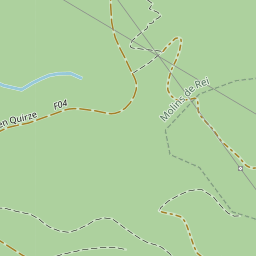

'OSM of area containing: 1 landuse forest  , 1 leisure nature reserve  .'

In [5]:
display(ds[0][0])
ds[0][1]

In [ ]:
hds = ds.to_huggingface_dataset()
hds.push_to_hub("mprzymus/text2tile_small")

In [ ]:
large_ds = TextToImageDataset("../data/tiles/").to_huggingface_dataset()
large_ds.push_to_hub("mprzymus/text2tile_large")

# Check download works

In [6]:
ds = load_dataset("mprzymus/text2tile")
test_captions = ds["test"]["caption"]

Found cached dataset parquet (/home/marcin/.cache/huggingface/datasets/mprzymus___parquet/mprzymus--text2tile-08c7471b58d60160/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
test_captions[843]

'OSM of area containing: 4 landuse meadows  , 3 landuse farmlands  , 1 natural scrub  , 1 natural water  , 1 water river  .'

In [14]:
test_captions[290]

'OSM of area containing: 2 leisure playgrounds  , 1 shop seafood  , 59 buildings  , 1 shop computer  , 1 office government  .'

In [15]:
test_captions[253]

'OSM of area containing: 2 leisure pitchs  , 191 building apartmentss  , 3 amenity parkings  , 1 amenity fuel  , 2 building industrials  .'

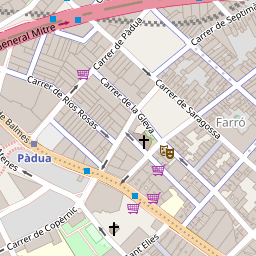

In [16]:
ds["test"]["image"][253]

In [11]:
from map_generation.osm_dataset import create_sentence

df = pd.read_csv("../data/tiles/Amsterdam, Netherlands/metadata.csv")
series = df[df["file_name"] == "33635_21524_16.png"].drop(columns=["file_name"])

create_sentence(series.squeeze(axis=0))

"waterway canal"
"landuse forest"
"highway service"
"shop wholesale"
"place suburb"


'OSM of area containing: 1 waterway canal, 1 landuse forest, 9 highway services , 1 shop wholesale, 1 place suburb.'

TypeError: list indices must be integers or slices, not str